In [1]:
import scipy.io
from plotly import graph_objs as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matrixprofile as mp
from matrixprofile import *
import glob
import operator
from os import path
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
from saxpy.hotsax import find_discords_hotsax
from numpy import genfromtxt
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
def plot_time_series(df, title=None, ano=None, ano_name='None'):
	fig = go.Figure()
	fig.add_trace(go.Scatter(y=df))
	if ano!=None:
		fig.add_trace(go.Scatter(y=df[ano], x=ano, name=ano_name))
	if title:
		fig.update_layout(title=title)
	return fig


                     value
datetime                  
1970-01-01 01:00:00  0.132
1970-01-01 01:00:01  0.134
1970-01-01 01:00:02  0.134
1970-01-01 01:00:03  0.134
1970-01-01 01:00:04  0.134
...                    ...
1970-01-01 02:07:07  0.132
1970-01-01 02:07:08  0.134
1970-01-01 02:07:09  0.134
1970-01-01 02:07:10  0.134
1970-01-01 02:07:11  0.134

[4032 rows x 1 columns]


ValueError: freq S not understood. Please report if you think this is in error.

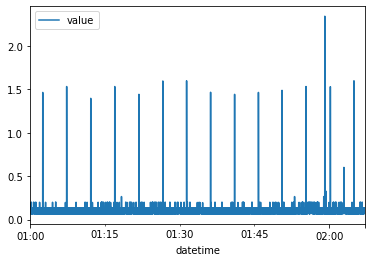

In [19]:
from datetime import datetime
base_file ='abnormal_point_datasets.xlsx'
base = pd.read_excel(base_file)

for idx, dataset in enumerate(base["Dataset"]):
    df=pd.read_csv("dataset/"+dataset, index_col=0)
    df["datetime"] =[datetime.fromtimestamp(i) for i in df.index.values]
    df=df.set_index('datetime')
    print(df)
    series = df
    df.plot()
    result = seasonal_decompose(df, model='additive')
    result.plot()
    pyplot.show()

** 0.34994112147414735 [2305]
** 0.3403204796743634 [2305]
** 0.25683057266603193 [2305]
** 0.21939367058592152 [2305, 154]
** 0.21939367058592152 [2305, 154]
** 0.21939367058592152 [2305, 154]
** 0.21939367058592152 [2305, 154]
** 0.21939367058592152 [2305, 154]
** 0.21939367058592152 [2305, 154]
** 0.21939367058592152 [2305, 154]
** 0.21939367058592152 [2305, 154, 428]
** 0.21939367058592152 [2305, 154, 428, 989]
[154, 269, 270, 271, 333, 334, 335, 428, 989, 2304, 2305, 2436]
0.21939367058592152
